In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('../data/berlin_weekdays.csv')
df.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,185.799757,Private room,False,True,2.0,True,0,0,10.0,98.0,1,3.582211,0.174706,105.063708,16.019042,148.941114,30.710638,13.42344,52.49150
1,1,194.914462,Private room,False,True,5.0,False,0,1,9.0,86.0,1,3.525410,0.511922,75.339529,11.487002,106.442356,21.947685,13.46800,52.51900
2,2,176.217631,Private room,False,True,2.0,False,0,0,9.0,91.0,1,3.801713,0.281397,73.669176,11.232324,105.440205,21.741048,13.47096,52.51527
3,3,207.768533,Private room,False,True,3.0,True,0,0,10.0,97.0,1,0.982408,0.705573,133.187409,20.307057,198.233362,40.874362,13.42281,52.53139
4,4,150.743199,Private room,False,True,2.0,False,0,0,10.0,99.0,1,8.869697,2.187188,39.860151,6.077469,50.996308,10.515090,13.52440,52.47842


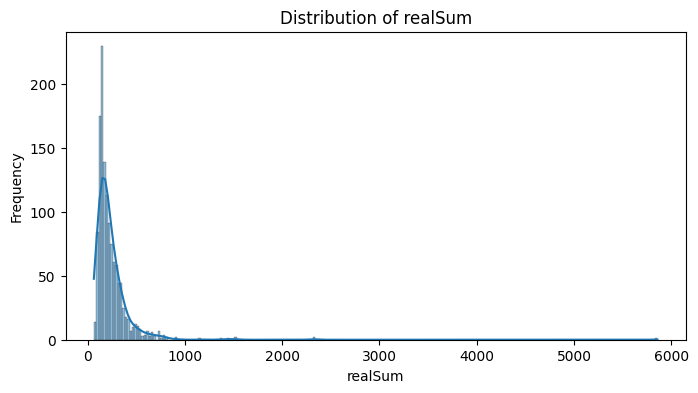

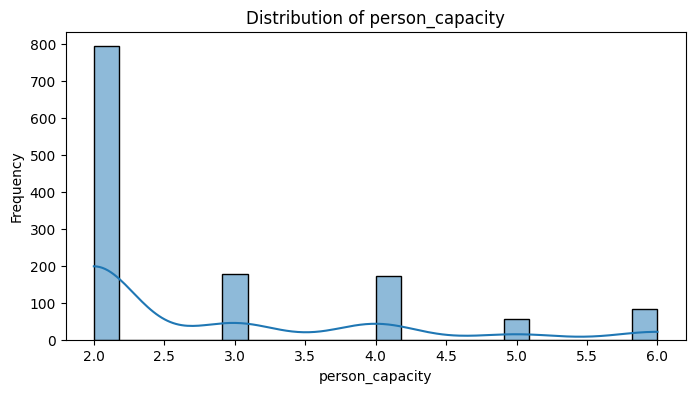

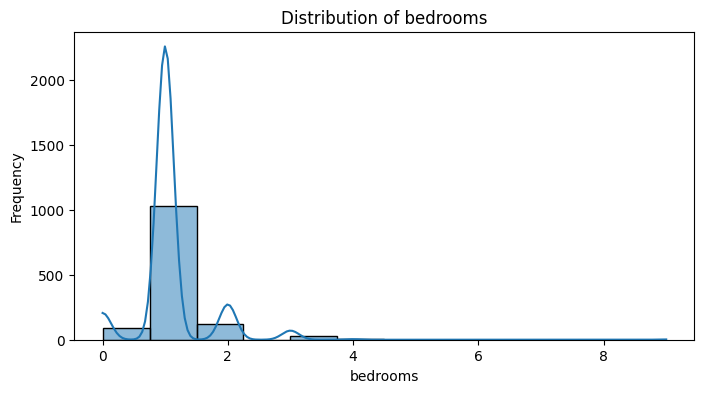

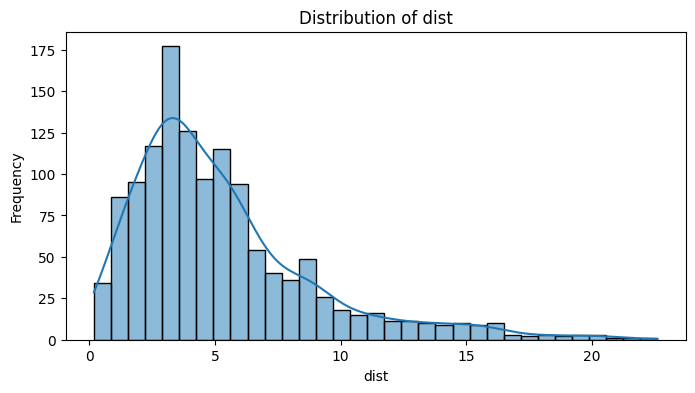

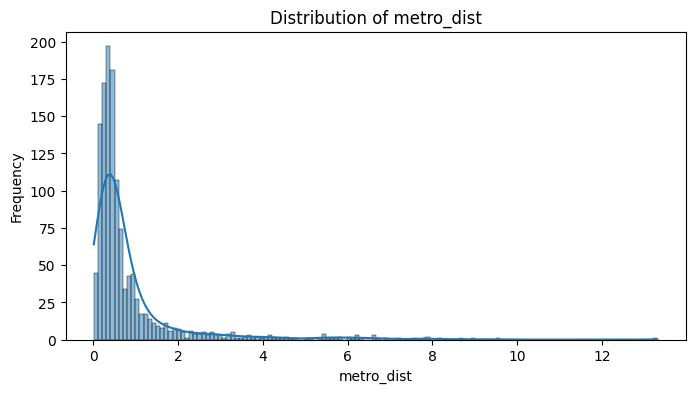

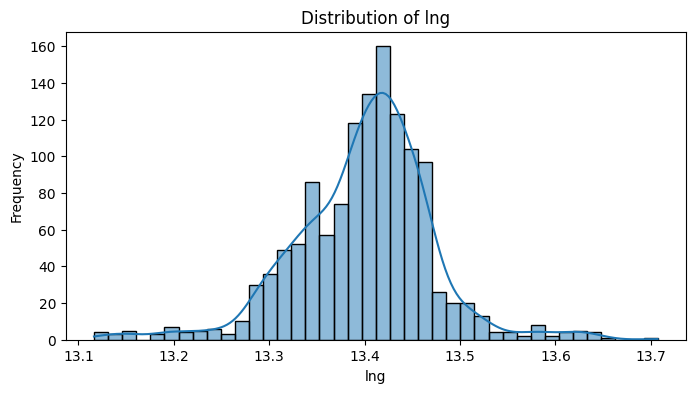

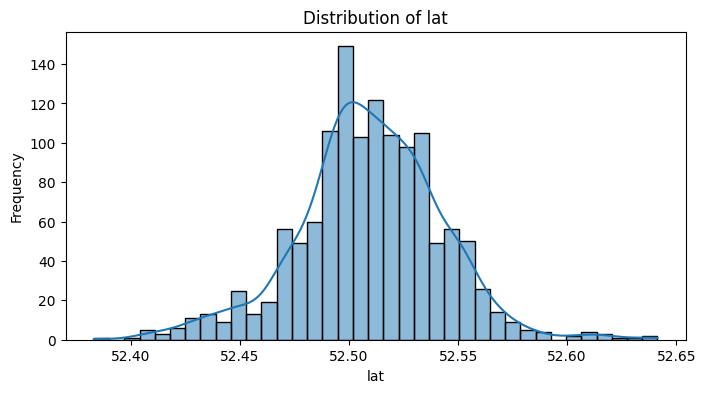

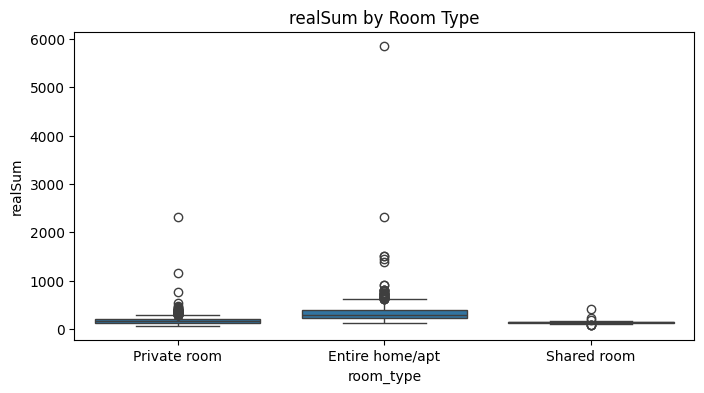

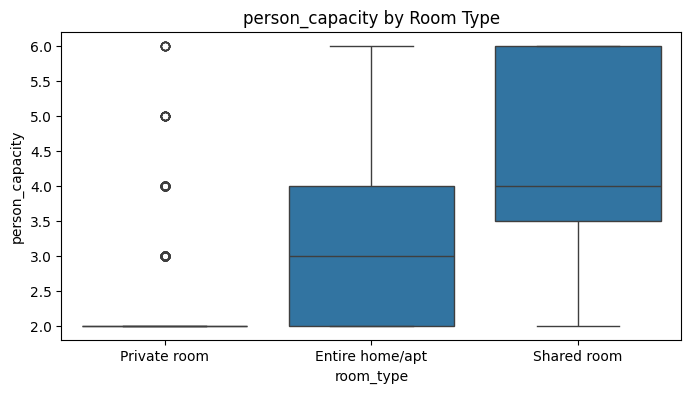

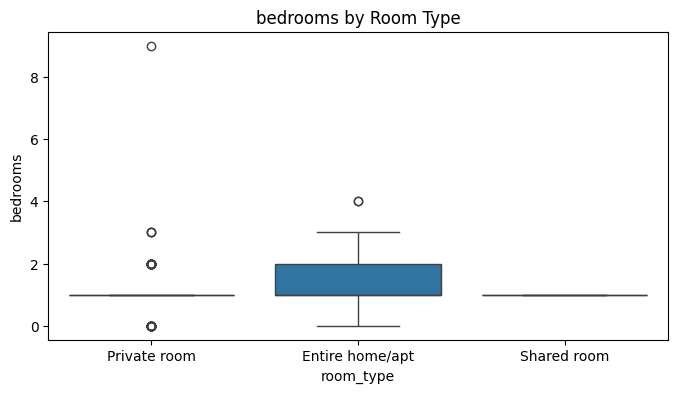

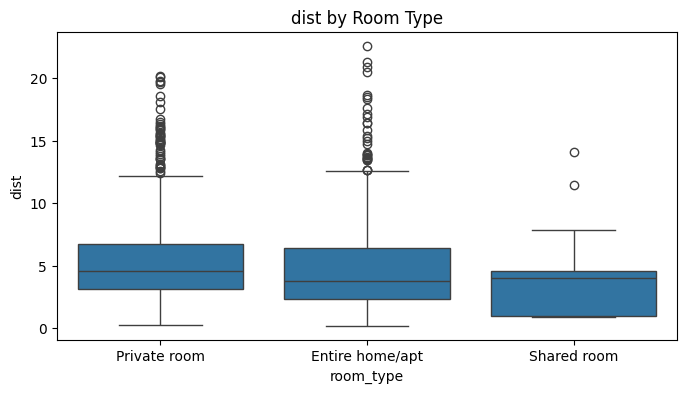

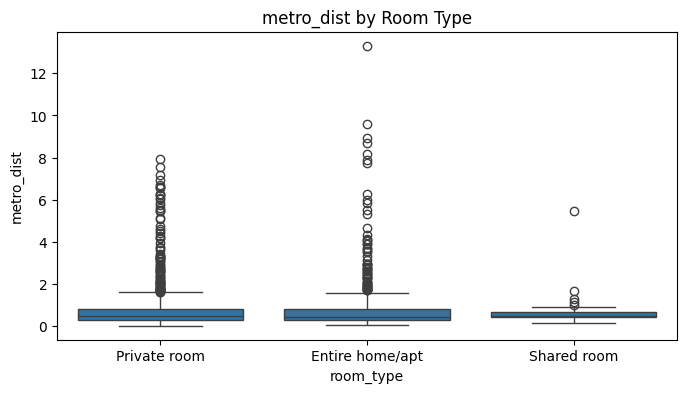

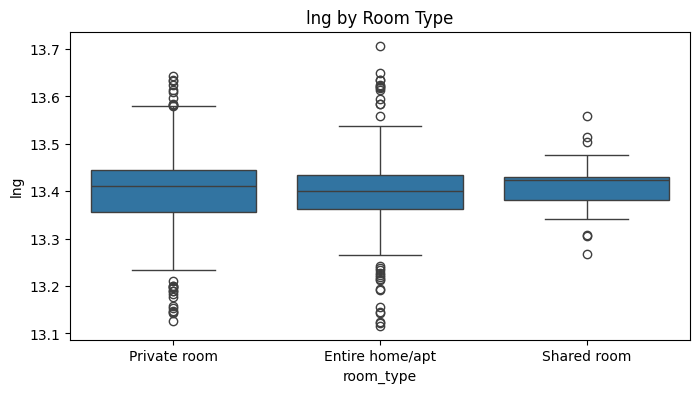

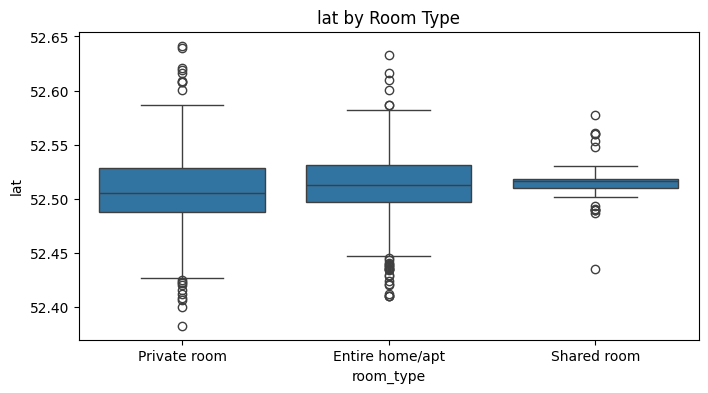

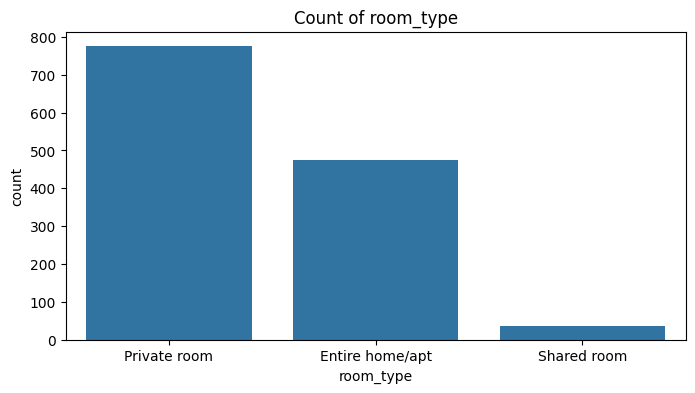

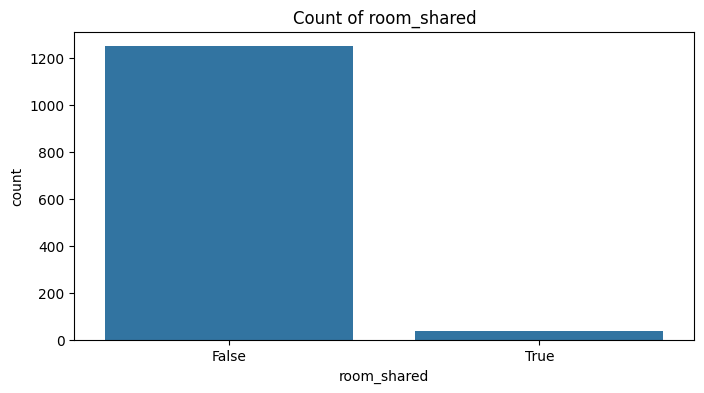

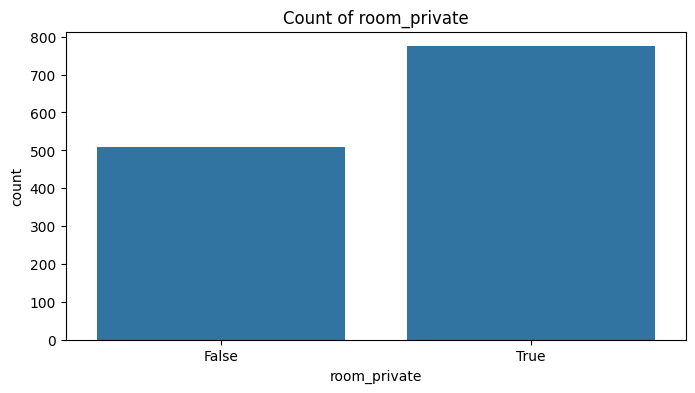

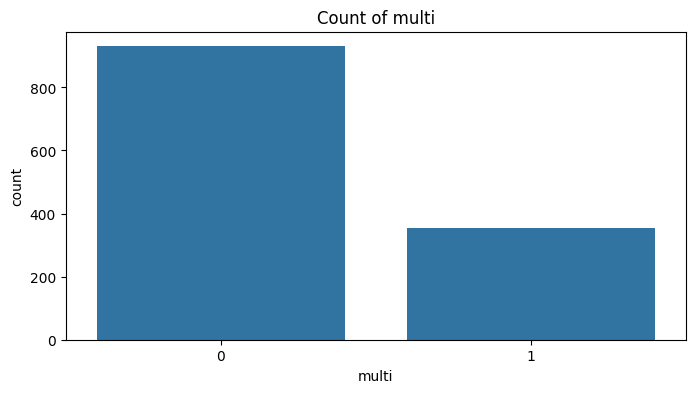

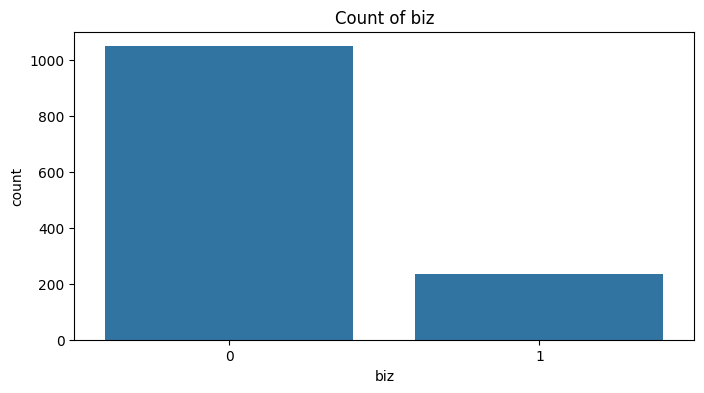

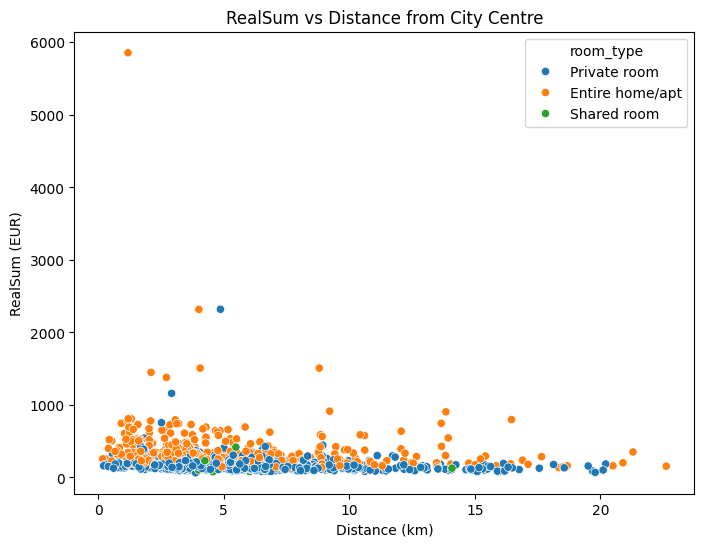

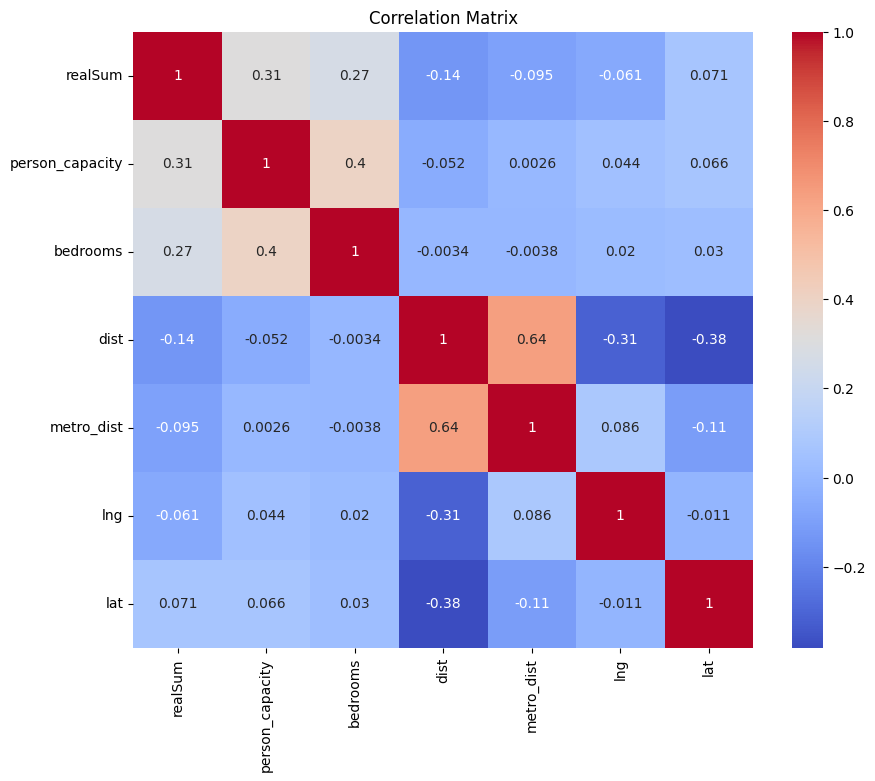

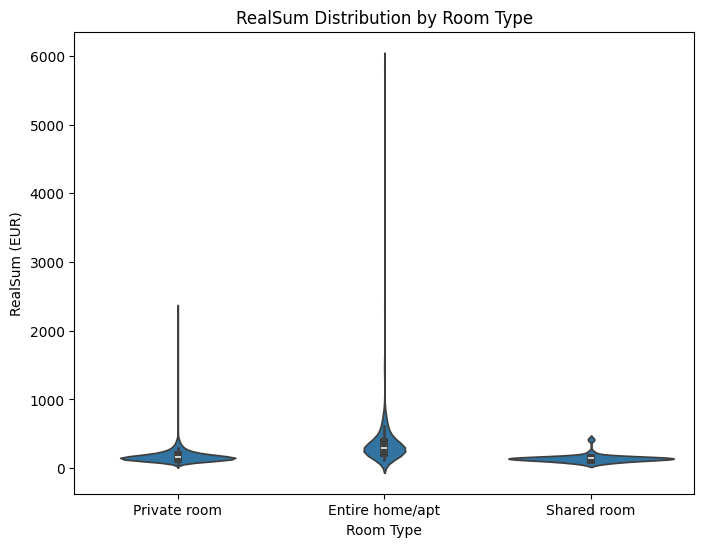

In [10]:

# Load the data
df = pd.read_csv('../data/berlin_weekdays.csv')

# Histograms for numeric variables
numeric_vars = ['realSum', 'person_capacity', 'bedrooms', 'dist', 'metro_dist', 'lng', 'lat']
for var in numeric_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

# Box plots for numeric variables by 'room_type'
for var in numeric_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='room_type', y=var, data=df)
    plt.title(f'{var} by Room Type')
    plt.show()

# Bar plots for categorical variables
categorical_vars = ['room_type', 'room_shared', 'room_private', 'multi', 'biz']
for var in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var, data=df)
    plt.title(f'Count of {var}')
    plt.show()

# Scatter plot for 'realSum' vs 'dist'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dist', y='realSum', hue='room_type', data=df)
plt.title('RealSum vs Distance from City Centre')
plt.xlabel('Distance (km)')
plt.ylabel('RealSum (EUR)')
plt.show()

# Heatmap for correlation analysis
corr_vars = df[numeric_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_vars, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Violin plots for 'realSum' by 'room_type'
plt.figure(figsize=(8, 6))
sns.violinplot(x='room_type', y='realSum', data=df)
plt.title('RealSum Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('RealSum (EUR)')
plt.show()
